In [1]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo

from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram, get_region_volume 
from constants import MASS_BINS, Z_MAX, LOG_MASS_LUMINOSITY_RATIO_BINS
from richard_curve import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_richards_curve, get_mass_luminosity_histogram

In [2]:
# functions for finding the cluster volume
def get_cluster_volume_sum_from_mass(mass, cluster_dataframe, z_min=0, z_max=999):
    cut_off_distance = get_max_distance_from_richards_curve(np.log10(mass))
    reduced_cluster_dataframe = cluster_dataframe[(cluster_dataframe['distance'] <= cut_off_distance) & (cluster_dataframe['z'] >= z_min) & (cluster_dataframe['z'] <= z_max)]
    return sum(reduced_cluster_dataframe["cluster_volume"])

def get_comoving_distance_from_redshift(redshift):
    return cosmo.comoving_distance(redshift).value

def get_sphere_volume(radius):
    return 4 / 3 * np.pi * radius ** 3

def get_max_distance_from_richards_curve(log_mass):
    A = -0.016
    K = 2742.0
    C = 0.9412
    B = 1.1483
    M = 11.815
    nu = 1.691
    y = A + (K - A) / (C + np.exp(-B * (log_mass - M))) ** (1 / nu)
    return y

def is_within_polygon(x, y):
    lower_bound_y = 1.3
    upper_bound_x = 1.7
    diagonal_y = (7/9) * x + 0.6778
    return (y >= lower_bound_y) & (x <= upper_bound_x) & (y >= diagonal_y)

def decide_galaxy_activity(u_minus_r_mag, r_minus_j_mag):
    if is_within_polygon(u_minus_r_mag, r_minus_j_mag):
        return 'quenched'
    else:
        return 'starforming'
    

In [3]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('../Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey
galaxies_raw = fits.open('../Data/fullmerged_gkvscienceStellarmass_Morphologyv02_shrinked.fits')[1].data

# cluster survey
clusters_raw = fits.open('../Data/eRASS/merged_primary&optical_clusters/merged_optical_primary_clusters.fits')[1].data  # eRASS western hemesphere

In [4]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 18,           # Font size for text
    'axes.titlesize': 18,      # Font size for axes titles
    'axes.labelsize': 16,      # Font size for x and y labels
    'xtick.labelsize': 16,     # Font size for x tick labels
    'ytick.labelsize': 16,     # Font size for y tick labels
    'legend.fontsize': 16,     # Font size for legend text
    'figure.figsize': (15, 8), # Default figure size
    'text.usetex': False
})

In [5]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < Z_MAX) &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < Z_MAX) &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        ~np.isnan(clusters_raw['VDISP_BOOT']) &     # Merged
        (clusters_raw['BEST_Z'] <= Z_MAX) &         # Merged
    (
        ((clusters_raw['RA'] > 129.0) & (clusters_raw['RA'] < 141.0) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 174.0) & (clusters_raw['RA'] < 186.0) & (clusters_raw['DEC'] > -3.0) & (clusters_raw['DEC'] < 2.0)) |
        ((clusters_raw['RA'] > 211.5) & (clusters_raw['RA'] < 223.5) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 339.0) & (clusters_raw['RA'] < 351.0) & (clusters_raw['DEC'] > -35.0) & (clusters_raw['DEC'] < -30.0))
    ) &
        (clusters_raw['R500'] != -1)             # Merged??????????????????????????????????????????????????
    
)

big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]

In [15]:
# completeness dataframe
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [16]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': cluster_catalog['DETUID'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['BEST_Z'].byteswap().newbyteorder(),
    'cluster_radius_kpc': cluster_catalog['R500'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP_BOOT'].byteswap().newbyteorder(),

})

# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
        'log_age': galaxy_catalog['logage'].byteswap().newbyteorder(),
        'log_tau': galaxy_catalog['logtau'].byteswap().newbyteorder(),
        'log_met': galaxy_catalog['logmet'].byteswap().newbyteorder(),
        'morphology': galaxy_catalog['FINAL_CLASS'].byteswap().newbyteorder(),
})

# Convert kpc to Mpc
cluster_df['cluster_radius_Mpc'] = cluster_df['cluster_radius_kpc'] / 1000

In [8]:
for morph in pd.unique(galaxy_df['morphology']):
    print(f"found {len(galaxy_df[galaxy_df['morphology'] == morph])} galaxies for morphology {morph}")

found 1324 galaxies for morphology E
found 4115 galaxies for morphology dBD
found 6729 galaxies for morphology D
found 2706 galaxies for morphology cBD
found 22 galaxies for morphology HE
found 77 galaxies for morphology H
found 100 galaxies for morphology C
found 3 galaxies for morphology star
found 168439 galaxies for morphology 


In [19]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)
matched_galaxy_dataframe.to_csv('matched_galaxy_df_with_bonus_parameters.csv')

Progress: 99.99945508541536%%%%%

In [9]:
# load matched galaxies
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [20]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner", on="uberID")

merged_galaxy_df['comoving_distance'] = cosmo.comoving_distance(merged_galaxy_df['z']).value

In [21]:
# apply selection function
mass_to_light_histogram_all_galaxies = get_mass_luminosity_histogram(galaxy_df=merged_galaxy_df)
mass_to_light_histogram_low_mass_galaxies = get_mass_luminosity_histogram(galaxy_df=merged_galaxy_df[merged_galaxy_df["mstar"] < 10**10])
mass_luminosity_cutoff = get_mass_luminosity_cutoff(merged_galaxy_df, cut_off_percentage=80)
mass_for_richards_curve = np.logspace(5,12.25, 1000)
richards_curve = get_distance_from_mass(mass_for_richards_curve, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
merged_galaxy_df['within_richards_curve'] = merged_galaxy_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_for_richards_curve, row['mstar'], row['comoving_distance']), axis=1)

In [22]:
# find the general mass function
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[merged_galaxy_df['within_richards_curve']], region_name='G09')
stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

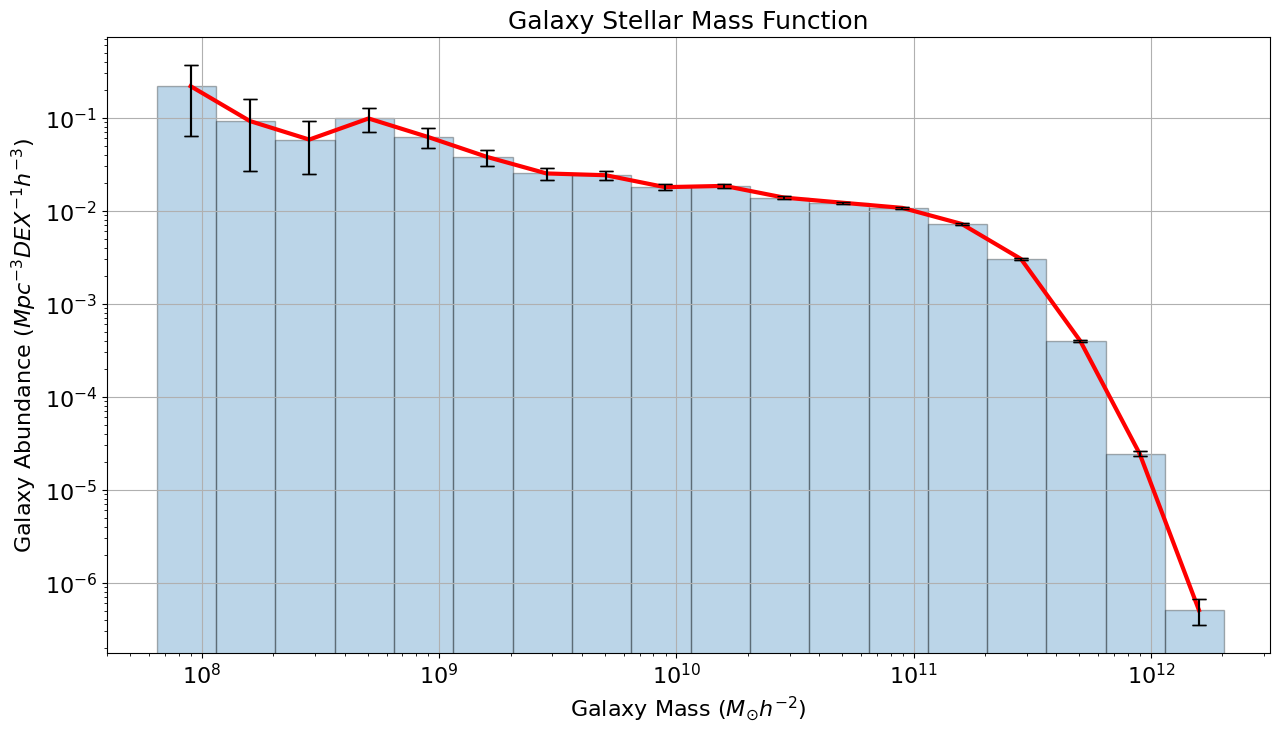

In [34]:
# plot the genral mass function
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers / 0.7**2, stellar_mass_function / 0.7**0, width=np.diff(MASS_BINS) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error / 0.7**0, capsize=5, alpha=0.3)

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function[10:] / 0.7**0, color='red', linewidth=3)
plt.bar(bin_centers / 0.7**2, stellar_mass_function / 0.7**0, width=np.diff(MASS_BINS) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error / 0.7**0, capsize=5, alpha=0.0)


plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.grid()

plt.title("Galaxy Stellar Mass Function")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-3}$)')
plt.savefig("../plots/mass_function.pdf")

In [14]:
# cluster volume

cluster_df['distance'] = get_comoving_distance_from_redshift(cluster_df["z"])
cluster_df['cluster_volume'] = get_sphere_volume(cluster_df['cluster_radius_Mpc'])

cluster_volumes_by_mass_bin = [get_cluster_volume_sum_from_mass(mass=mass, cluster_dataframe=cluster_df, z_max=0.4) for mass in MASS_BINS]

In [15]:
# find the mass function for field galaxies
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[(merged_galaxy_df['within_richards_curve']) & (merged_galaxy_df["environment"] == "Field")], region_name='G09')
stellar_mass_function_field = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_field = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

In [16]:
# and cluster galaxies
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[(merged_galaxy_df["within_richards_curve"] == True) & (merged_galaxy_df["environment"] == "ClusterMember")], region_name='G09')
stellar_mass_function_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

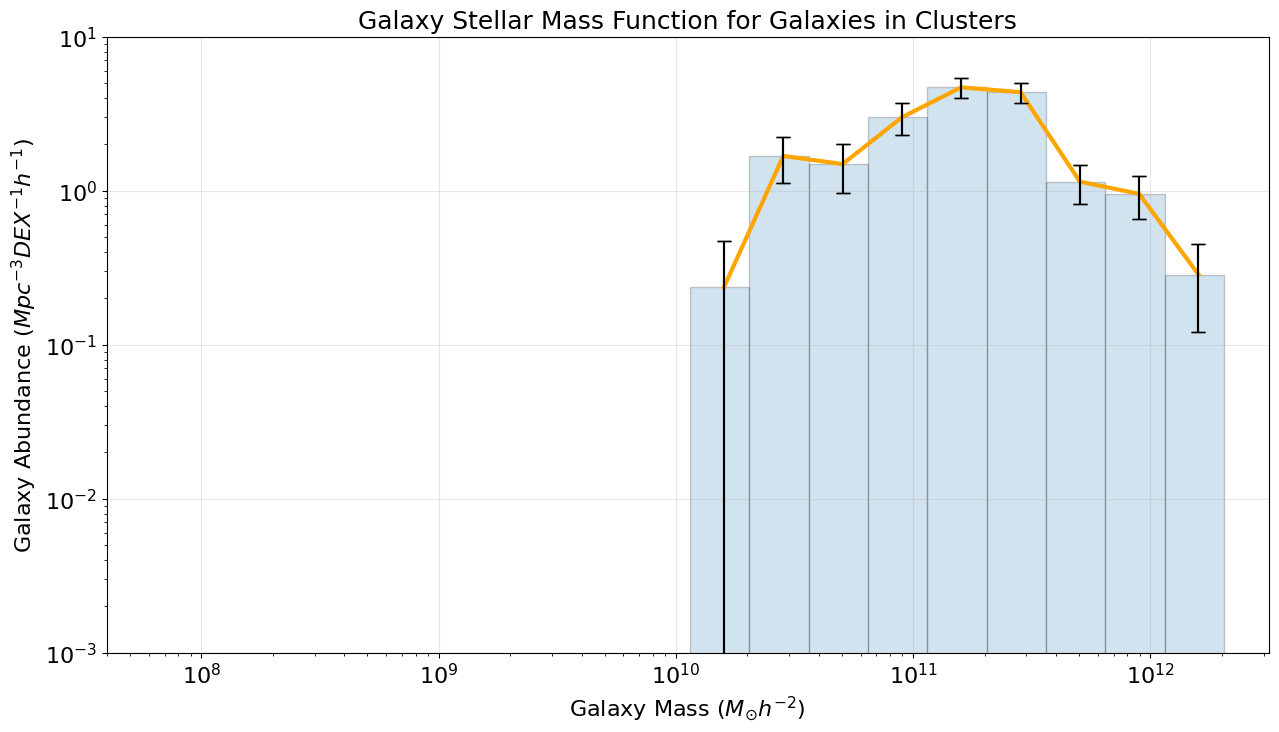

In [56]:
# plot the cluster function
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster / 0.7, capsize=5, alpha=0.2)

plt.plot(bin_centers[19:] / 0.7**2, stellar_mass_function_cluster[12:] / 0.7, color='orange', linewidth=3)
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster / 0.7, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.ylim(10**-3, 10**1)
plt.grid(alpha=0.3)

plt.title("Galaxy Stellar Mass Function for Galaxies in Clusters")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-1}$)')
plt.savefig("../plots/mass_function_cluster_galaxies.pdf")

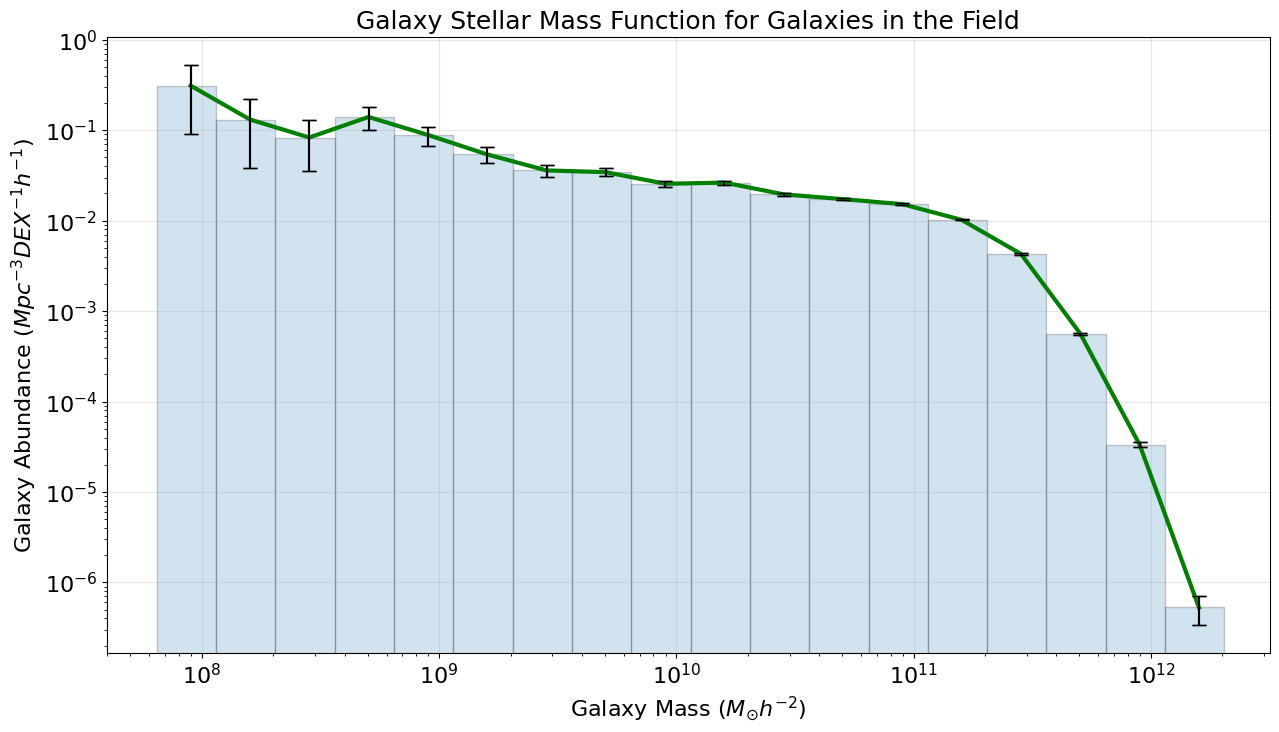

In [55]:
# plot the field function
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_field[7:] / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:] / 0.7, capsize=5, alpha=0.2)

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function_field[10:] / 0.7, color='green', linewidth=3)
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_field[7:] / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:] / 0.7, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.grid(alpha=0.3)

plt.title("Galaxy Stellar Mass Function for Galaxies in the Field")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-1}$)')
plt.savefig("../plots/mass_function_field_galaxies.pdf")

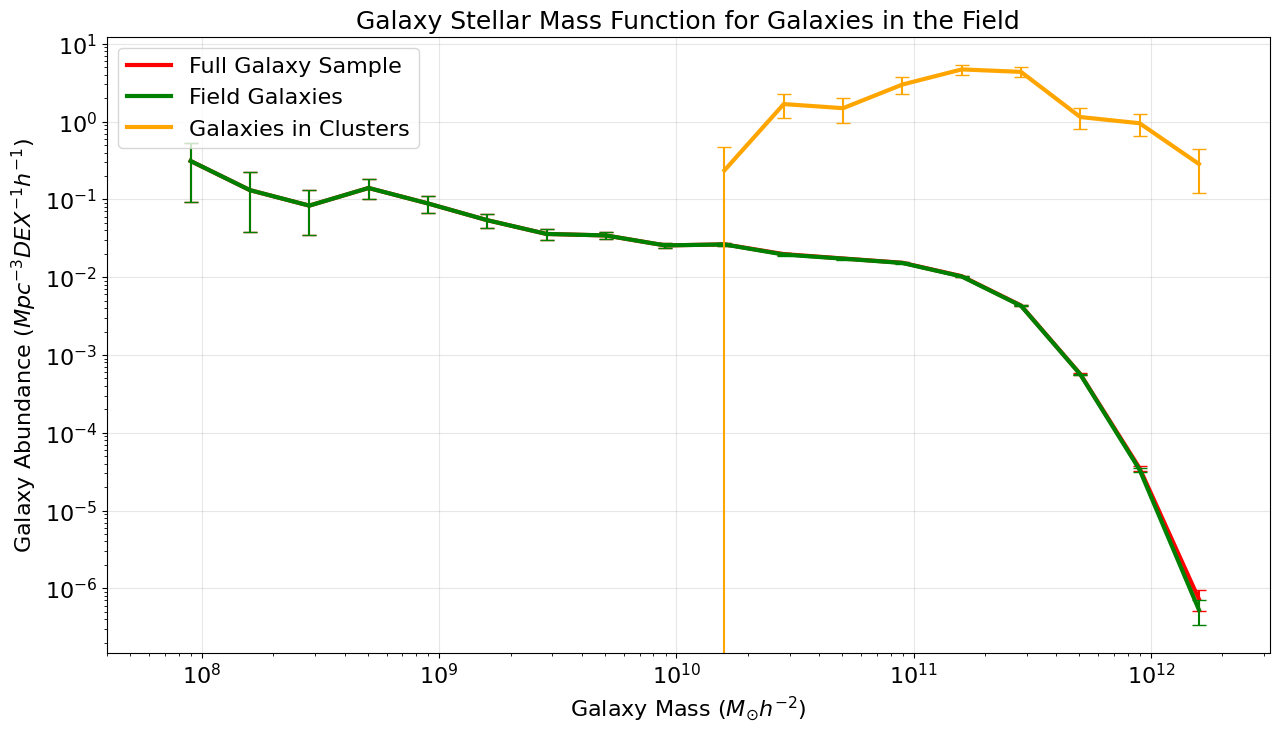

In [53]:
# plot all three functions together
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
#plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_field[7:] / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:] / 0.7, capsize=5, alpha=0.2)

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function[10:] / 0.7, color='red', linewidth=3, label="Full Galaxy Sample", alpha=1)
plt.bar(bin_centers / 0.7**2, stellar_mass_function / 0.7, width=np.diff(MASS_BINS) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error / 0.7, capsize=5, alpha=0.0, ecolor="red")

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function_field[10:] / 0.7, color='green', linewidth=3, label="Field Galaxies")
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_field[7:] / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:] / 0.7, capsize=5, alpha=0.0, ecolor="green")

plt.plot(bin_centers[19:] / 0.7**2, stellar_mass_function_cluster[12:] / 0.7, color='orange', linewidth=3, label="Galaxies in Clusters")
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster / 0.7, capsize=5, alpha=0.0, ecolor="orange")

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.grid(alpha=0.3)

plt.title("Galaxy Stellar Mass Function for Galaxies in the Field")
#plt.xlabel("Galaxy Mass (M_sol / h^2)")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-1}$)')
plt.legend()
plt.savefig("../plots/mass_function_all_galaxies.pdf")

In [27]:
# find the mass functions for galaxies by age group
median_age = merged_galaxy_df["log_age"].median()
print(f"median age: {median_age}")

# young
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_age"] < median_age)
        ],
    region_name='G09'
    )
stellar_mass_function_young = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_young = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# old
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_age"] > median_age)
        ],
    region_name='G09'
    )
stellar_mass_function_old = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_old = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

median age: median_age


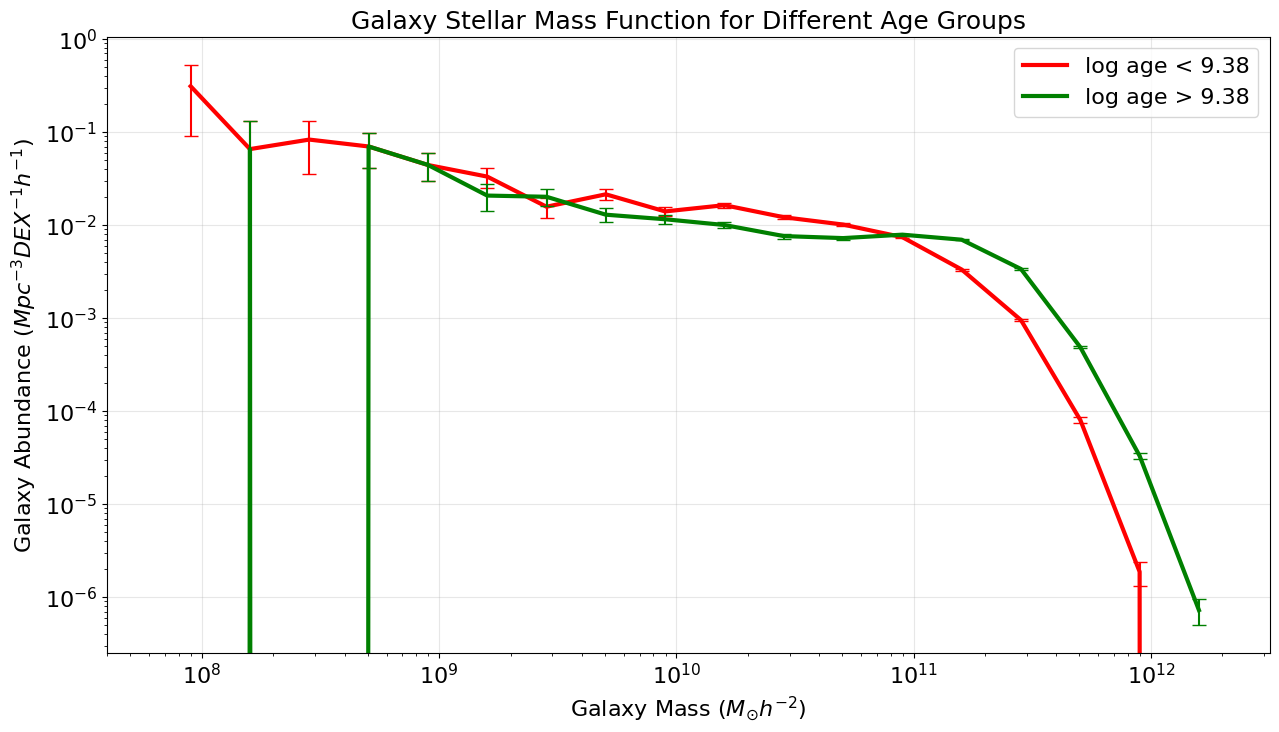

In [28]:
# plot the different age groups
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function_young[10:] / 0.7, color='red', linewidth=3, label="log age < 9.38")
plt.bar(bin_centers / 0.7**2, stellar_mass_function_young / 0.7, width=np.diff(MASS_BINS) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_young / 0.7, capsize=5, alpha=0.0, ecolor="red")

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function_old[10:] / 0.7, color='green', linewidth=3, label="log age > 9.38")
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_old[7:] / 0.7, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_old[7:] / 0.7, capsize=5, alpha=0.0, ecolor="green")

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.grid(alpha=0.3)

plt.title("Galaxy Stellar Mass Function for Different Age Groups")
#plt.xlabel("Galaxy Mass (M_sol / h^2)")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-1}$)')
plt.legend()
plt.savefig("../plots/mass_function_by_age_group.pdf")